In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import re

##### Read features as dataframes

In [2]:
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [3]:
year_name = [f'Landsat_{year}' for year in year_range[:-2]] + [f'Sentinel_{year}' for year in year_range[-2:]]

In [4]:
# import the points with image values 
feature_df = [pd.read_csv(f'./Data/{name}.csv') for name in year_name]

# merge all pt_with_img and remove unnecessary columns
feature_df = [fe.drop(['system:index','.geo','split'],axis=1) for fe in feature_df]

##### train_test_split and apply randomforest_classifier

In [12]:
grid_acc_list = []

for year,fe in zip(year_range,feature_df):
    
    # _______________________________Different band combination_______________________________
    
    col_name = ''.join(fe.columns)
    
    # find the spectrum band names
    Spectrum_reg = re.compile(r'(B6_VCID_\d|B\d{1,2}|Landsat_B\d{1,2}|Sentinel_B\d{1,2})')
    Spectrum_reg_bands = Spectrum_reg.findall(col_name)
    
    # find the Mean-nomalized names
    Mean_nomalize_reg   = re.compile(r'Mean_\w{2,3}I')
    Mean_nomalize_bands = Mean_nomalize_reg.findall(col_name)
    
    # find the Fourire names
    Fourier_reg   = re.compile(r'((EVI|NDBI|NDVI)_(constant|\w{3}_\d))')
    Fourier_bands = [i[0] for i in Fourier_reg.findall(col_name)]
    
    # get the terrain bands
    Terrain_bands = ['DEM','SLOPE']
    
    # get the meterology bands
    Meterology_bands = ['lrad', 'prec', 'pres', 'shum', 'srad', 'temp', 'wind']
    
    
    
    #_________________________________Assess the accuracy ______________________________________
    
    bands_in = zip(['Spectrum',
                    'Spectrum_Normalize',
                    'Spectrum_Normalize_Fourier',
                    'Spectrum_Normalize_Fourier_Terrain',
                    'Spectrum_Normalize_Fourier_Terrain_Meterology'],
                   
                   [Spectrum_reg_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands + Terrain_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands + Terrain_bands + Meterology_bands])
    
    
    
    # ________________________Grid search to compare the accuracy under different input bands__________
    
    for band_name, bands_select in bands_in:
    
        # get the X and y
        X = fe[bands_select]
        y = fe['Built']

        # appliy RandomForestClassifier 
        classifier = RandomForestClassifier()

        # Use gridSearch
        param_grid = dict(n_estimators = range(1,120))    
        grid = GridSearchCV(classifier,param_grid,cv=4,scoring='accuracy',n_jobs=-1,verbose=2)
        grid.fit(X,y)


        # fetch the accuracy value from grid result
        grid_df = pd.DataFrame(grid.cv_results_)
        grid_select = grid_df[[s for s in grid_df.columns if 'param_' in s or 'split' in s]]
        
        # convert the acc_df to long format and add 'Year' and 'in_band_name' column
        grid_long = pd.DataFrame(grid_select.set_index('param_n_estimators').stack())
        grid_long.reset_index(inplace=True)
        grid_long.columns = ['Tree','CrossFolds','Accuracy']
        grid_long['Year'] = year
        grid_long['In_Bands'] = band_name

        grid_acc_list.append(grid_long)

        # print out the process
        
        print(f'{band_name}_{year}')
        print(f'___________________________________')
        print()
        

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   44.1s finished


Spectrum_1990_1992
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   46.8s finished


Spectrum_Normalize_1990_1992
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.5min finished


Spectrum_Normalize_Fourier_1990_1992
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.6min finished


Spectrum_Normalize_Fourier_Terrain_1990_1992
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.0min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_1990_1992
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   44.3s finished


Spectrum_1993_1995
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   53.3s finished


Spectrum_Normalize_1993_1995
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.7min finished


Spectrum_Normalize_Fourier_1993_1995
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.7min finished


Spectrum_Normalize_Fourier_Terrain_1993_1995
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.0min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_1993_1995
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   40.8s finished


Spectrum_1996_1998
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   48.4s finished


Spectrum_Normalize_1996_1998
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.6min finished


Spectrum_Normalize_Fourier_1996_1998
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.6min finished


Spectrum_Normalize_Fourier_Terrain_1996_1998
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.1min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_1996_1998
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   42.6s finished


Spectrum_1999_2001
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   50.4s finished


Spectrum_Normalize_1999_2001
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.7min finished


Spectrum_Normalize_Fourier_1999_2001
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.7min finished


Spectrum_Normalize_Fourier_Terrain_1999_2001
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.1min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_1999_2001
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   41.9s finished


Spectrum_2002_2004
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   50.0s finished


Spectrum_Normalize_2002_2004
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.7min finished


Spectrum_Normalize_Fourier_2002_2004
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.7min finished


Spectrum_Normalize_Fourier_Terrain_2002_2004
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.1min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2002_2004
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   45.4s finished


Spectrum_2005_2007
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   50.3s finished


Spectrum_Normalize_2005_2007
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.7min finished


Spectrum_Normalize_Fourier_2005_2007
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.7min finished


Spectrum_Normalize_Fourier_Terrain_2005_2007
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.2min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2005_2007
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   41.9s finished


Spectrum_2008_2010
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   48.8s finished


Spectrum_Normalize_2008_2010
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.6min finished


Spectrum_Normalize_Fourier_2008_2010
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.8min finished


Spectrum_Normalize_Fourier_Terrain_2008_2010
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.0min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2008_2010
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   48.2s finished


Spectrum_2011_2013
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   49.1s finished


Spectrum_Normalize_2011_2013
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.6min finished


Spectrum_Normalize_Fourier_2011_2013
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.6min finished


Spectrum_Normalize_Fourier_Terrain_2011_2013
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.0min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2011_2013
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.3min finished


Spectrum_2014_2016
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.4min finished


Spectrum_Normalize_2014_2016
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.9min finished


Spectrum_Normalize_Fourier_2014_2016
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.3min finished


Spectrum_Normalize_Fourier_Terrain_2014_2016
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.3min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2014_2016
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.3min finished


Spectrum_2017_2019
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.5min finished


Spectrum_Normalize_2017_2019
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.0min finished


Spectrum_Normalize_Fourier_2017_2019
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.3min finished


Spectrum_Normalize_Fourier_Terrain_2017_2019
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.3min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2017_2019
___________________________________



In [15]:
# # save the grid_acc 
# grid_acc = pd.concat(grid_acc_list).reset_index().drop('index',axis = 1)
# grid_acc['Year'] = grid_acc['Year'].astype('category')
# grid_acc.to_csv('./Result/Grid_acc_tree.csv',index = False)

# load the grid_acc
grid_acc = pd.read_csv('./Result/Grid_acc_tree.csv')
grid_acc['Year'] = grid_acc['Year'].astype('category')

In [16]:
grid_acc

,Tree,CrossFolds,Accuracy,Year,In_Bands
0,1,split0_test_score,0.784182,1990_1992,Spectrum
1,1,split1_test_score,0.781355,1990_1992,Spectrum
2,1,split2_test_score,0.754527,1990_1992,Spectrum
3,1,split3_test_score,0.773307,1990_1992,Spectrum
4,2,split0_test_score,0.748660,1990_1992,Spectrum
...,...,...,...,...,...
23795,118,split3_test_score,0.947786,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23796,119,split0_test_score,0.936592,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23797,119,split1_test_score,0.948481,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23798,119,split2_test_score,0.952444,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology


##### Observe that the tree number of 100 is enough for classification

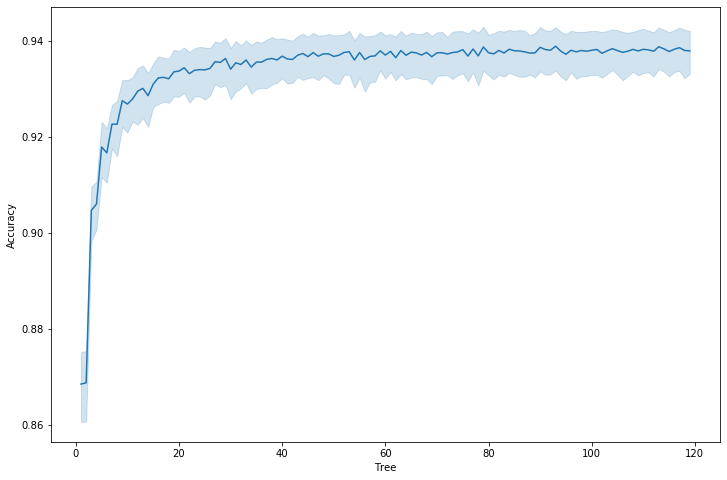

In [29]:
plt.figure(figsize=(12,8))
sns.lineplot(data = grid_acc[grid_acc['In_Bands']=='Spectrum_Normalize_Fourier_Terrain_Meterology'],
             x='Tree',
             y='Accuracy')

##### Observe that the Fourier bands significant increases the accuracy

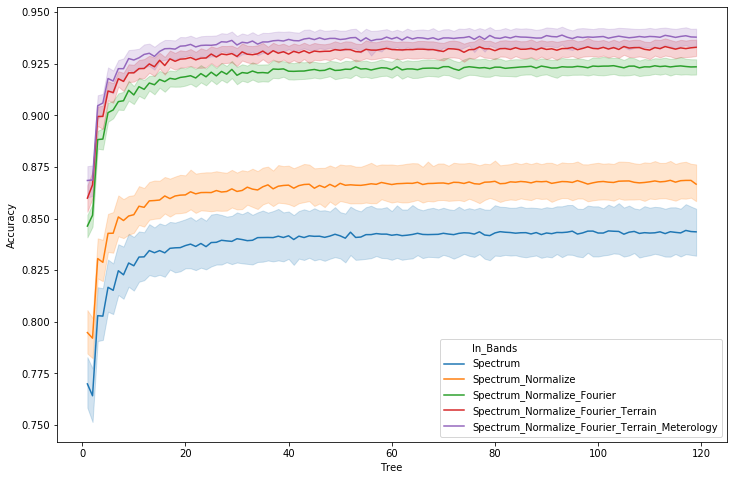

In [31]:
plt.figure(figsize=(12,8))
sns.lineplot(data = grid_acc,
             x='Tree',
             y='Accuracy',
             hue = 'In_Bands')

##### Observe that the using seperate control sample for 2014-2017 and 2017-2019 siginifacntly increases the accuracy

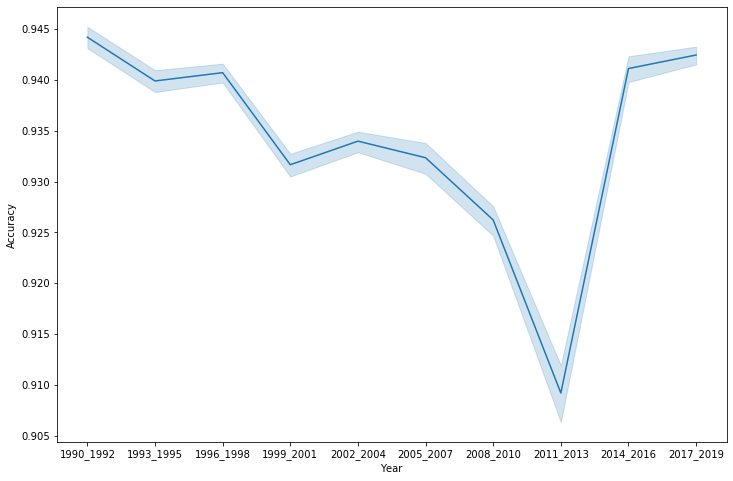

In [24]:
plt.figure(figsize=(12,8))
sns.lineplot(data = grid_acc[grid_acc['In_Bands']=='Spectrum_Normalize_Fourier_Terrain_Meterology'],
             x='Year',
             y='Accuracy')